# Data Fusion Contest. Goodsification

Задача от ВТБ:  Data Fusion Contest: https://boosters.pro/championship/data_fusion/data

Необходимо разработать алгоритм определения категории товара по данным из чеков, смоделированных в соответствии с реальным профилем данных ОФД. Все зависимости между различными товарами в чеках сохранены. Тренировочный датасет содержит более 8 000 000 уникальных чеков, из них около 800 000 чеков размечены и около 7 000 000 чеков без разметки. Товары без определенной категории отмечены "-1". Тестовый датасетсостоит из ~400 000 чеков, метрика считается только на уникальных item name, которые отсутствуют в тренировочном датасете.

Признаки:

receipt_id — id чека;
receipt_dayofweek — день недели;
receipt_time — время создания чека;
item_name — наименование товара;
item_quantity — количество товара;
item_price — цена товара;
item_nds_rate — ставка НДС;
category_id — категория товара.

# Часть 1: препроцессинг и первая модель LinearSVC

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, GroupShuffleSplit, train_test_split, GroupKFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from nltk.corpus import stopwords 

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import itertools

import scipy
from scipy.sparse import coo_matrix, hstack
import pickle
import re

from dask import dataframe as dd 
import dask.array as da



### Загрузка  данных

In [2]:
data_path='F:\\Data_Science\\competitions\\Data Fusion Contest VTB\\data'
data= pd.read_parquet(data_path+'\\train.parquet')

Удаляем Nan, потом они будут нам мешать:

In [3]:
data.fillna('', inplace=True)

In [4]:
data

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.000,7,-1,-1,вертекс
1,11,6,20:34,"Молоко 3,2%,шт",2.000,8,2,78,
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.000,6,1,-1,
3,39,4,11:28,"Компот из изюма, 114 ккал",1.000,4,1,71,
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.000,4,1,71,
...,...,...,...,...,...,...,...,...,...
45729304,10016159,4,12:39,"Карам.""Ломтик""апел/лимон/грейфр. 1кг Яшкино",0.283,10,-1,-1,
45729310,10016159,4,12:39,СМЕТАНА 20% Залесский Фермер 200 г. пл.ст.,1.000,7,6,-1,залесский фермер
45729312,10016159,4,12:39,Слива Черная Пантера 1кг,0.439,11,-1,-1,
45729314,10016159,4,12:39,"Хлеб ""Заварной"" ржано-пшен. 0,4г нарезка Берез.",1.000,8,-1,-1,


Наш датасет содержит более 26 млн. строк, однако среди них есть очень много неразмеченных данных (category_id=-1) и дублей:

In [5]:
print(f'Датасет содержит: {round(len(data[data.category_id==-1]) / 10**6, 1)} млн. неразмеченных строк')

Датасет содержит: 19.6 млн. неразмеченных строк


Удалим неразмеченные строки (чуть позже мы к ним вернемся) и дубли среди наименований товаров. Однако перед удалением дублей сгенерируем несколько агрегирующих признаков по наименованиям товаров, которые будут использоваться в тиоговой модели. Идея взята в открытом решении тут: https://github.com/exotol/data_fusion_vtb

In [6]:
gr_item_name = data.groupby('item_name')
data['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
data['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
data['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
data['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
data['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

data['mean_item_price'] = gr_item_name['item_price'].transform("mean")
data['sum_item_price'] = gr_item_name['item_price'].transform("sum")
data['std_item_price'] = gr_item_name['item_price'].transform("std")
data['min_item_price'] = gr_item_name['item_price'].transform("min")
data['max_item_price'] = gr_item_name['item_price'].transform("max")

data['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
data['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
data['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
data['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
data['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


data['hours'] = data['receipt_time'].apply(lambda x: int(x.split(":")[0]))

data['mean_hours'] = gr_item_name['hours'].transform("mean")
data['sum_hours'] = gr_item_name['hours'].transform("sum")
data['std_hours'] = gr_item_name['hours'].transform("std")
data['min_hours'] = gr_item_name['hours'].transform("min")
data['max_hours'] = gr_item_name['hours'].transform("max")


data['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
data['median_dayofweek'] = data['median_dayofweek'].astype(np.int8)

В ходе решения пытались генерировать аналогичные агрегационные признаки по чекам (receipt_id), но в итоговую модель они не вошли, так как не давали увеличения скора.

Теперь удаляем дубли:

In [7]:
train =data[data.category_id != -1].drop_duplicates('item_name').reset_index(drop=True)

Отдельно оставим неразмеченные строки для обучения word2vec

In [8]:
train_wt = train[train.category_id == -1].drop_duplicates('item_name')

In [9]:
train

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,...,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek
0,11,6,20:34,"Молоко 3,2%,шт",2.000,8,2,78,,1.341835,...,0.000000,2,2,20,15.450960,58760,3.495831,0,23,3
1,39,4,11:28,"Компот из изюма, 114 ккал",1.000,4,1,71,,1.201849,...,1.258344,1,6,11,11.724191,7609,4.223616,0,23,4
2,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.000,4,1,71,,1.082397,...,1.310625,1,6,11,11.788015,15737,4.518246,0,23,2
3,56,5,11:42,Кофе Капучино Большой Эден 18,1.000,12,1,70,,1.102445,...,0.000000,1,1,11,12.299185,10565,4.941394,0,23,3
4,105,3,01:53,Хлеб на СЫВОРОТКЕ 350г,1.000,7,-1,84,,1.217787,...,0.370090,-1,6,1,14.378151,20532,6.034693,0,23,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48220,9880594,2,20:11,"Напиток Энерг. Ред Булл 0,355л",1.000,10,6,83,,1.000000,...,NaN,6,6,20,20.000000,20,NaN,20,20,2
48221,9908635,5,01:09,Хеменгуэй Дайкири,1.000,15,6,0,,1.000000,...,NaN,6,6,1,1.000000,1,NaN,1,1,5
48222,9929539,0,14:39,"Пиво светлое ""Халзан"" 4,5 % об, пл/б. 1,5 л(шт)",1.000,10,6,0,,1.000000,...,NaN,6,6,14,14.000000,14,NaN,14,14,0
48223,9932986,3,22:26,Экспресс педикюр,1.000,15,6,42,,1.000000,...,NaN,6,6,22,22.000000,22,NaN,22,22,3


Наш датасет сократился до 48 тыс. строк.

### Предобработка данных

Предварительная обработка данных: приведение к нижнему регистру (стандартно), небольшая ручная корректировка наименований. 

Некоторый прирост скора (около 0,003 на паблике) дала замена латинских букв их русскими аналогами:

In [10]:
def clean_text(df):
    df["item_name"] = df["item_name"].apply(lambda x: x.lower())

    for symbol in [",", "%", "(", ")", "." , "\'", "/", "-", "_", "/", "\""]:
        df["item_name"] = df["item_name"].apply(lambda x: x.replace(symbol, " "))

    df["item_name"] = df["item_name"].apply(lambda x: x.replace("ржано", "ржаной "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("нач ", "начинкой "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace(" нач", " начинкой "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("orbit", " орбит "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("жев рез", " жевательная резинка "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("ж р ", " жевательная резинка "))
    
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("\"", " \" "))
    
    #v2
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("0 75вин", " вино "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace(" рыбн ", " рыбная "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("морепродуктами", " морепродукты "))
    
    #v3
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("snickers", " сникерс "))
    
    #v4
    df["item_name"] = df["item_name"].apply(lambda x: x.replace(" kуриная ", " куриная "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace(" kотлета ", " котлета "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace(" kофе ", " кофе "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("kофе ", "кофе "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace(" kофе", " кофе"))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("kофе", "кофе"))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace(" kаппучино ", " каппучино "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("сапоги", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("туфли", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("полусапоги", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("кеды высокие", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("кеды мужские", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("кеды женские", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("кеды детские", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("кеды муж", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("сандалии", " обувь "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("пижама", " пижам "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("пижамный", " пижам "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("пижамные", " пижам "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("для сна", " пижам "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("сорочка дет", " пижам "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("сорочка женская", " пижам "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("сорочка жен", " пижам "))
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("сорочка подростковая", " пижам ")) 
    df["item_name"] = df["item_name"].apply(lambda x: x.replace("kомплект", " комплект "))

    #v5
    df['item_name'] = df['item_name'].str.replace('№', '')
    df['item_name'] = df['item_name'].str.replace('%', '')
    df['item_name'] = df['item_name'].str.replace('╣', '')
    df['item_name'] = df['item_name'].str.replace('"', '')
    df['item_name'] = df['item_name'].str.replace('<', '')
    df['item_name'] = df['item_name'].str.replace('>', '')
    df['item_name'] = df['item_name'].str.replace('#', '')
    df['item_name'] = df['item_name'].str.replace('_', '')
    df['item_name'] = df['item_name'].str.replace('+', '')
    df['item_name'] = df['item_name'].str.replace('-', '')
    df['item_name'] = df['item_name'].str.replace('&', '')
    df['item_name'] = df['item_name'].str.replace('  ', ' ')
    df['item_name'] = df['item_name'].str.replace('a', 'а')
    df['item_name'] = df['item_name'].str.replace('h', 'н')
    df['item_name'] = df['item_name'].str.replace('k', 'к')
    df['item_name'] = df['item_name'].str.replace('b', 'в')
    df['item_name'] = df['item_name'].str.replace('c', 'с')
    df['item_name'] = df['item_name'].str.replace('o', 'о')
    df['item_name'] = df['item_name'].str.replace('p', 'р')
    df['item_name'] = df['item_name'].str.replace('t', 'т')
    df['item_name'] = df['item_name'].str.replace('x', 'х')
    df['item_name'] = df['item_name'].str.replace('y', 'у')
    df['item_name'] = df['item_name'].str.replace('e', 'е')
    df['item_name'] = df['item_name'].str.replace('m', 'м')
    df['item_name'] = df['item_name'].str.replace('  ', ' ')
    df['item_name'] = df['item_name'].str.lstrip()
    
    
clean_text(train)
clean_text(train_wt)

train["item_name"]

0                                            молоко 3 2 шт
1                                 компот из изюма 114 ккал
2        макаронные изделия отварные масло сливочное 24...
3                            кофе капучино большой эден 18
4                                   хлеб на сыворотке 350г
                               ...                        
48220                        напиток энерг ред булл 0 355л
48221                                    хеменгуэй дайкири
48222            пиво светлое халзан 4 5 об пл б 1 5 л шт 
48223                                     экспресс педикюр
48224                  конфеты харитоша 1кг мол ваф яшкино
Name: item_name, Length: 48225, dtype: object

Теперь текст приведен к тому виду, с которым мы будем в дальнейшем работать. 

Разобьем наименования товаров на токены для последующей подачи в Word2vec. 

In [11]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[\d.,]+|[A-Z][.A-Z]+\b\.*|\w+|\S')

train["tokens"] = train["item_name"].apply(lambda x: [e.lower() for e in tokenizer.tokenize(x)])
train_wt["tokens"] = train_wt["item_name"].apply(lambda x: [e.lower() for e in tokenizer.tokenize(x)])

train.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,...,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek,tokens
0,11,6,20:34,молоко 3 2 шт,2.0,8,2,78,,1.341835,...,2,2,20,15.450960,58760,3.495831,0,23,3,"[молоко, 3, 2, шт]"
1,39,4,11:28,компот из изюма 114 ккал,1.0,4,1,71,,1.201849,...,1,6,11,11.724191,7609,4.223616,0,23,4,"[компот, из, изюма, 114, ккал]"
2,39,4,11:28,макаронные изделия отварные масло сливочное 24...,1.0,4,1,71,,1.082397,...,1,6,11,11.788015,15737,4.518246,0,23,2,"[макаронные, изделия, отварные, масло, сливочн..."
3,56,5,11:42,кофе капучино большой эден 18,1.0,12,1,70,,1.102445,...,1,1,11,12.299185,10565,4.941394,0,23,3,"[кофе, капучино, большой, эден, 18]"
4,105,3,01:53,хлеб на сыворотке 350г,1.0,7,-1,84,,1.217787,...,-1,6,1,14.378151,20532,6.034693,0,23,3,"[хлеб, на, сыворотке, 350, г]"


Посмотрим на наиболее ярких представителей своих классов:

In [12]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

89


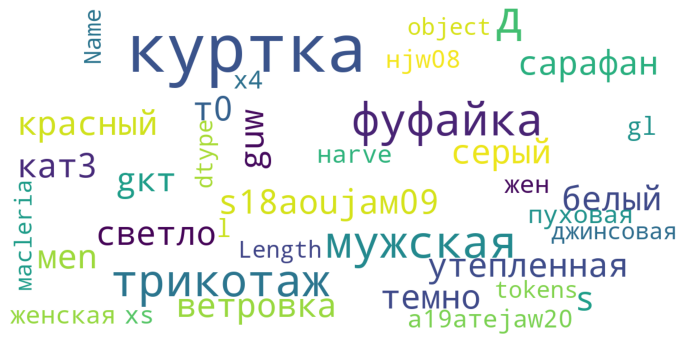

In [13]:
cat_num = 54

print(len(train[train["category_id"] == cat_num]))

show_wordcloud(train[train["category_id"] == cat_num]["tokens"])

4771


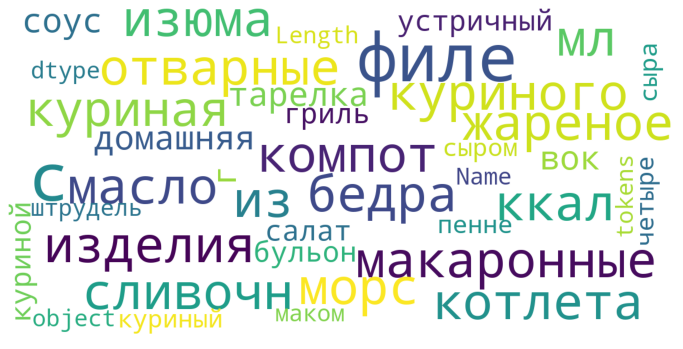

In [14]:
cat_num = 71

print(len(train[train["category_id"] == cat_num]))

show_wordcloud(train[train["category_id"] == cat_num]["tokens"])

815


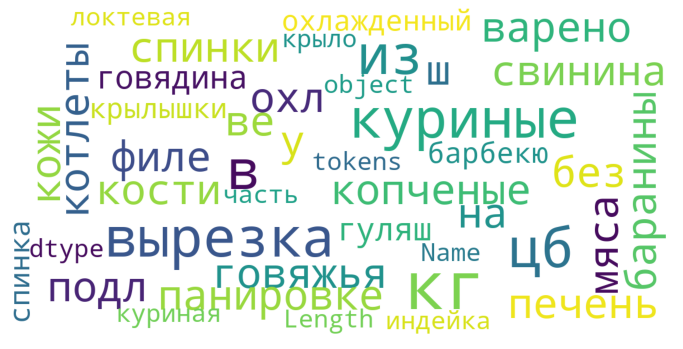

In [15]:
cat_num = 79

print(len(train[train["category_id"] == cat_num]))

show_wordcloud(train[train["category_id"] == cat_num]["tokens"])

Мы видим, что одной из сложностей данной задачи являются трудно разделимые классы. Например, "куриное филе" может относиться как к 71 классу (если это блюдо в кафе), так и к 79 (если оно куплено в магазине). Аналогично морс, компот, чай, кофе и т.д. Таких наименований очень много... 

### Идея алгоритма

Идея нашего решения заключается в следующем:
1. Строим предсказания классов на основе только наименований товаров (word2vec+tfidf+LinearSVC). Эта модель на паблике дала скор 0,8546.
2. С помощью данной модели прогнозируем классы для всех строк исходного датасета (в том числе дубли и неразчеченные).
3. Имеющиеся категории товаров делим на укрупненные группы (все, что связано с автомобилями, канцелярия и печатная продукция, кафе/рестораны, продуктовые магазины и т.д.)
4. Для каждого чека находим наиболее популярную группу товаров и делаем из нее отдельную фичу (так мы можем разделить, например, рестораны и продуктовые магазины)
5. Добавляем ранее сгенерированные агрегированные признаки по категориям чеков
6. И все это подаем в catboost.

Т.о. в итоговый catboost попадают: item_name, аналог вероятности отнесения к классам по прогнозу LinearSVC (decision_function), сам прогноз класса, наиболее популярная группа товаров в чеке, некоторые агрегирующие фичи.

Итак... поехали 

### Word2vec+tfidf+LinearSVC

Обучаем word2vec на размеченных и неразмеченных данных

In [16]:
# Обучение word2vec.

#tokens_1 = train.groupby("receipt_id")["tokens"].apply(lambda x: list(itertools.chain(*x.tolist()))).tolist()
#tokens_2 = train_wt.groupby("receipt_id")["tokens"].apply(lambda x: list(itertools.chain(*x.tolist()))).tolist()

#common_texts = tokens_1 + tokens_2
#model = Word2Vec(sentences=common_texts, window=4, min_count=1, workers=1, size=100, seed=42)
#model.save("word2vec.model")

In [17]:
import numpy as np

def get_sentence_vector(model, words_list):
    size = len(words_list)
    sentence_vector = np.zeros(100)
    
    for word in words_list:
        try:
            sentence_vector += model.wv[word]
        except Exception:
            size -= 1
            
    if size > 0:
        sentence_vector /= size
        
    return sentence_vector

In [18]:
#загружаем ранее сохраненную модель. Каждый раз переучивать не надо
model = Word2Vec.load("word2vec.model")
X_train2 = pd.DataFrame(np.array([get_sentence_vector(model, tokens) for tokens in train["tokens"]]))
scl = MinMaxScaler()
X_train2 = scl.fit_transform(X_train2)

X_train2

array([[0.36797252, 0.40989529, 0.33785179, ..., 0.38822256, 0.46591974,
        0.37823147],
       [0.44901878, 0.53315504, 0.4695047 , ..., 0.51440952, 0.51799426,
        0.63236886],
       [0.40124635, 0.44888604, 0.40772199, ..., 0.34294717, 0.63700427,
        0.67839185],
       ...,
       [0.46656074, 0.48461645, 0.29547685, ..., 0.4383508 , 0.398603  ,
        0.45868045],
       [0.53933538, 0.50950666, 0.43698845, ..., 0.23606718, 0.61241956,
        0.48033307],
       [0.33155403, 0.44605487, 0.24624491, ..., 0.4542638 , 0.54367515,
        0.53744299]])

In [19]:
tfidf = TfidfVectorizer(use_idf=True,
                        sublinear_tf=True, 
                        max_features=85000, 
                        ngram_range=(1,5), 
                        analyzer='char_wb', 
                        max_df=0.5,
                        min_df=1)

tfidf.fit(train.item_name)
X_train1 = tfidf.transform(train.item_name)


X = hstack([X_train1, scipy.sparse.csr_matrix(X_train2)])

In [20]:
clf = LinearSVC(random_state=42,
                penalty="l2",
                loss="squared_hinge",
                dual=True,
                C=0.9168112634441202,
                tol=0.31071850432096737)

cross_val_score(clf, X, train.category_id, cv=3, scoring='f1_weighted')

array([0.85495776, 0.84145554, 0.81232742])

In [21]:
clf.fit(X, train.category_id)

LinearSVC(C=0.9168112634441202, random_state=42, tol=0.31071850432096737)

In [22]:
import pickle

pickle.dump(tfidf, open('tfidf', 'wb'))
pickle.dump(clf, open('clf_task1', 'wb'))
pickle.dump(scl, open('scl', 'wb'))

### Добавление к признакам прогноза LinearSVC по фолдам

В итоговой модели catboost будут использоваться прогнозы LinearSVC. Чтобы не получить жесткое обучение, прогноз LinearSVC добавляем по принципу out of fold:

In [23]:
from sklearn.model_selection import  GroupKFold

X_meta = np.zeros((X.shape[0], 96))
X_meta_pred = np.zeros((X.shape[0],))
gkf = list(GroupKFold(n_splits=10).split(X, train.category_id, train.receipt_id.values))
for fold_i, (train_i, test_i) in enumerate(gkf):
    print(fold_i)
    model = LinearSVC(random_state=42,
                penalty="l2",
                loss="squared_hinge",
                dual=True,
                C=0.9168112634441202,
                tol=0.31071850432096737)
    model.fit(X.tocsr()[train_i], train.category_id.iloc[train_i])
    X_meta[test_i, :] = model.decision_function(X.tocsr()[test_i])
    X_meta_pred[test_i] = model.predict(X.tocsr()[test_i])

0
1
2
3
4
5
6
7
8
9


In [24]:
X_meta_df=pd.DataFrame(X_meta, columns=clf.classes_)

In [25]:
train=pd.concat([train,X_meta_df],axis=1)
train['pred_category']=X_meta_pred

In [26]:
train.pred_category=train.pred_category.apply(int)

In [27]:
train

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,...,140,145,150,163,164,167,177,203,204,pred_category
0,11,6,20:34,молоко 3 2 шт,2.000,8,2,78,,1.341835,...,-1.645560,-2.074830,-1.773687,-1.155365,-1.396777,-1.243571,-1.283344,-1.923077,-0.823047,78
1,39,4,11:28,компот из изюма 114 ккал,1.000,4,1,71,,1.201849,...,-1.959644,-2.214672,-1.566025,-1.643045,-1.323290,-1.651574,-1.772448,-1.544172,-1.205885,71
2,39,4,11:28,макаронные изделия отварные масло сливочное 24...,1.000,4,1,71,,1.082397,...,-2.414406,-2.793309,-1.888707,-1.696378,-1.740464,-1.952517,-2.075659,-1.803656,-1.737307,71
3,56,5,11:42,кофе капучино большой эден 18,1.000,12,1,70,,1.102445,...,-2.198889,-1.955634,-1.440650,-1.763510,-1.503111,-1.571048,-1.288924,-1.550939,-1.720797,70
4,105,3,01:53,хлеб на сыворотке 350г,1.000,7,-1,84,,1.217787,...,-1.860771,-1.668605,-1.616847,-1.430661,-1.468567,-1.704392,-1.892704,-1.770578,-1.994474,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48220,9880594,2,20:11,напиток энерг ред булл 0 355л,1.000,10,6,83,,1.000000,...,-1.627006,-1.728058,-1.453545,-1.607081,-1.732438,-1.576928,-1.648788,-2.028287,-1.909255,83
48221,9908635,5,01:09,хеменгуэй дайкири,1.000,15,6,0,,1.000000,...,-0.918825,-1.402329,-1.254272,-1.418075,-1.233247,-1.269933,-1.221510,-1.297557,-1.027336,0
48222,9929539,0,14:39,пиво светлое халзан 4 5 об пл б 1 5 л шт,1.000,10,6,0,,1.000000,...,-1.897982,-1.556777,-1.588117,-1.285349,-1.282035,-1.669484,-1.642056,-2.050478,-1.746628,0
48223,9932986,3,22:26,экспресс педикюр,1.000,15,6,42,,1.000000,...,-1.327328,-1.879888,-1.030403,-1.373911,-1.384096,-1.302766,-1.568963,-1.598994,-1.299507,42


### Добавление дополнительных  признаков для catboost

Добавим признаки, помогающие в классификации наименований товаров. Идея взята в открытом решении тут: https://github.com/exotol/data_fusion_vtb

In [28]:
def create_features(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
     
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')
    
    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)
    
    data['last_first_word'] = data['last'] + data['first']
    return data

In [29]:
train = create_features(train)

In [30]:
def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df

In [31]:
train = fill_median(train)

In [32]:
train.to_csv('train_without_receipt_type.csv',encoding='utf-8-sig')

Итак, мы выполнили пункты 1, 2 и 5 нашего плана. Для генерации признака "тип чека" необходимо строить прогноз LinearSVC для всего исходного датасета. В связи с огромным объемом данных, вынесем это в следующую часть нашего решения.